#  License Plate Grabber
ECE 278A - Image Processing<br/>
Winter 2022<br/>

Created By:<br/>
Roger Lin (yuxilin@ucsb.edu)<br/>
Taian Song (taiansong@ucsb.edu)


## Objective
The objective of this project is to seperate license plates from images of cars using image processing techniques introduced in the lectures. License Plate Recognition (LPR) is a well known image processing technology. LPR system consists of four steps: capture the image from digital camera, pre-processing, character segmentation and character recognition. License plates are available in various styles and colors in various countries.

## Introduction
The data set we use from Caltech contains 126 images of cars taken from the rear as shown below. 
http://www.vision.caltech.edu/Image_Datasets/cars_markus/cars_markus.tar

Algorithm:<br/>
-> Load images from database  <br/>
-> Smoothing target image using gaussian filtering <br/>
-> Separate the rear of the vehicle <br/>
-> Transformation<br/>
-> Plate recognition using contour detection <br/>
-> Histogram equalization <br/>
-> Binarization <br/>

### Packages
Packages used in this project are:
numpy, matlplotlib, math, skimage, and cv2

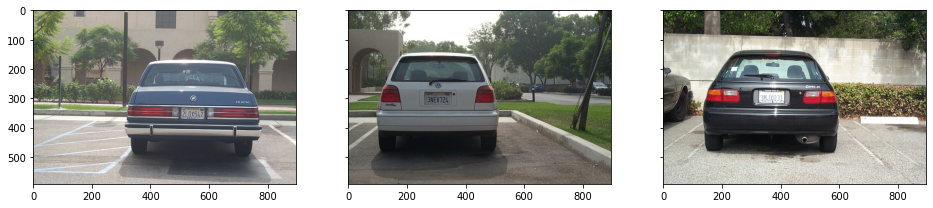

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv
from skimage import data, segmentation, color, measure, exposure
from skimage.future import graph
from skimage.filters import threshold_local

from lib.img_load import *

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,figsize=(16, 18))
ax[0].imshow(img_load('data/cars_markus/image_0001.jpg'))
ax[1].imshow(img_load('data/cars_markus/image_0002.jpg'))
ax[2].imshow(img_load('data/cars_markus/image_0003.jpg'))

## Methods
### Segmentation
Since all cars tend to have consistant color, segmentation can be used to seperate shapes out of the image, here region splitting and merging is applied, with weight factor favoring color than proximity.

Number of Segments:17


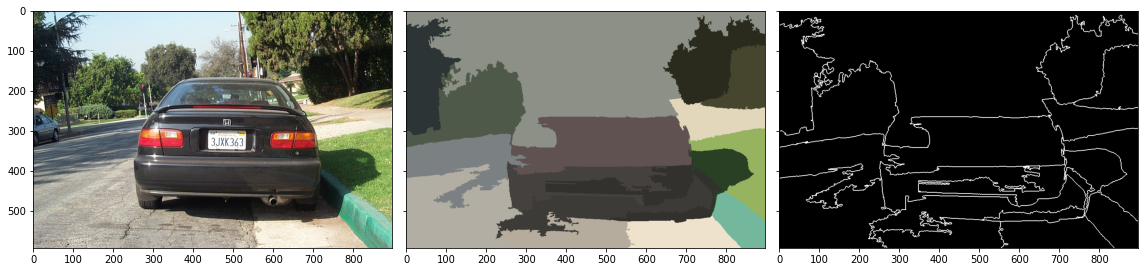

In [4]:
def img_seg(img):
    # Split and merge
    labels1 = segmentation.slic(img, compactness=0.1, n_segments=40, sigma = 1, convert2lab=True)
    out1 = color.label2rgb(labels1, img, kind='avg', bg_label=40)
    # Adjust RAG merge with threshold
    g = graph.rag_mean_color(img, labels1)
    labels2 = graph.cut_threshold(labels1, g, 1)
    out2 = color.label2rgb(labels2, img, kind='avg', bg_label=1)
    # Find edges
    boundries = segmentation.find_boundaries(labels2)

    fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                           figsize=(16, 18))
    ax[0].imshow(img)
    ax[1].imshow(out1)
    ax[2].imshow(boundries, cmap='gray')

    plt.tight_layout()
    segment_num = len(np.unique(labels2))
    print('Number of Segments:' + str(segment_num))
    
    return labels2


img = img_load('data/cars_markus/image_0020.jpg')
#img = img_load('data/cars_markus/image_0017.jpg')
# img = img_load('data/cars_markus/image_0075.jpg')
seg_labels = img_seg(img)

Then the segment that has the centroid closest to the center of the image is found as the segment that contains the license plate.

In [5]:
def find_rear_box(labels2):
    reg_props = measure.regionprops(labels2)
    reg_dist_com = np.zeros(len(reg_props))
    for idx in range(len(reg_props)):
        (x, y) = reg_props[idx].centroid
        dist = math.sqrt((x - (500.0/2))**2 + (y - (896.0/2))**2)
        reg_dist_com[idx] = dist
    rear_label = np.argmin(reg_dist_com)
    
    # Coordinates of selected segment
    segment_coords = reg_props[rear_label].coords
    # Coordinates of selected segment's boundry box
    box_coords = reg_props[rear_label].bbox
    
    return segment_coords, box_coords


(region_coords, box_coords) = find_rear_box(seg_labels)
print(box_coords)

(261, 262, 410, 713)


The rear region can be cropped out for the next steps.

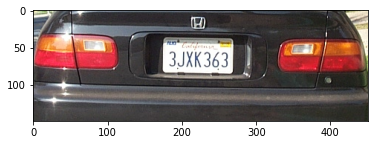

In [7]:
def extract_region(img, region_coords, box_coords):
    region = np.zeros_like(img)
    (min_row, min_col, max_row, max_col) = box_coords
    for coord in region_coords:
        row = coord[0]
        col = coord[1]
        region[row, col, :] = img[row, col, :]
        region_cropped = img[min_row:max_row, min_col:max_col, :]
        
    return region_cropped


plate_area = extract_region(img, region_coords, box_coords)
plt.imshow(plate_area, cmap='gray')
plt.show()

### Contour Detection
With the rear part of the vehicle identified we are able to find the rectangle that has specific height to width ratio and size inside the image, which correspond to the features of the license plate.

Plate found:


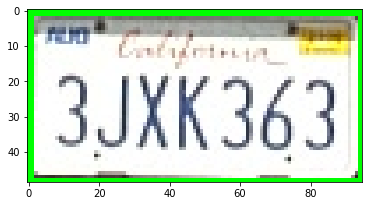

In [8]:
def find_plate(plate_area):
    im = np.zeros_like(plate_area)
    im = plate_area
    imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    count = 0
    for contour in contours:
        (x,y,w,h) = cv.boundingRect(contour)
        # w to h ratio
        rat = w/h
        if abs(rat - 2) <= 0.2 and w >= 50 and w <= 150:
            count = count + 1
            print('Plate found:')
            plate = im[y:y + h, x:x + w, :]
            cv.rectangle(im, (x,y), (x+w,y+h), (0,255,0), 2)
            plt.imshow(plate, cmap='gray')       
            return plate

    if count == 0:
        print('No plate found:')
        return -1
            
    
plate = find_plate(plate_area)

### Histrogram Equalization
Adaptive histrogram equalization can be used to bring up the contrast of the plate.

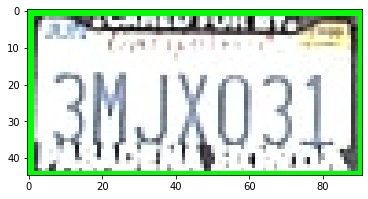

In [15]:
def hist_eq(image):
    # Apply adaptive Equalization
    image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
    return image_adapteq


plate_eq = hist_eq(plate)
# Show result
plt.imshow(plate_eq, cmap='gray')

### Binarization for Text Recognition
Using local thresholding, the plate is further processed to binary image, allowing further processing.

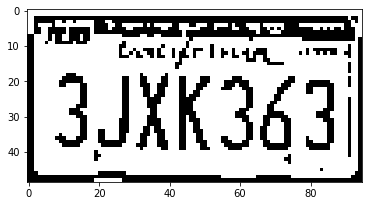

In [10]:
def img_bin(image_adapteq):
    img = color.rgb2gray(image_adapteq)
    block_size = 21
    loc_thres = threshold_local(img, block_size)
    loc_bin = img > loc_thres
    plt.imshow(loc_bin, cmap='gray')
    
    return loc_bin


plate_bin = img_bin(plate_eq)

## Results
The 10 images are processed as shown below.

Number of Segments:16
No plate found:
Number of Segments:14
No plate found:
Number of Segments:16
No plate found:
Number of Segments:15
Plate found:
Number of Segments:13
No plate found:
Number of Segments:24
No plate found:
Number of Segments:22
No plate found:
Number of Segments:17
No plate found:
Number of Segments:12
No plate found:
Number of Segments:15
No plate found:
Number of Segments:16
Plate found:


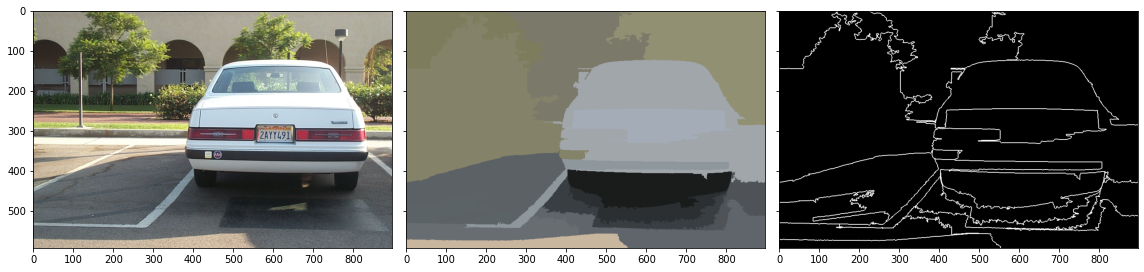

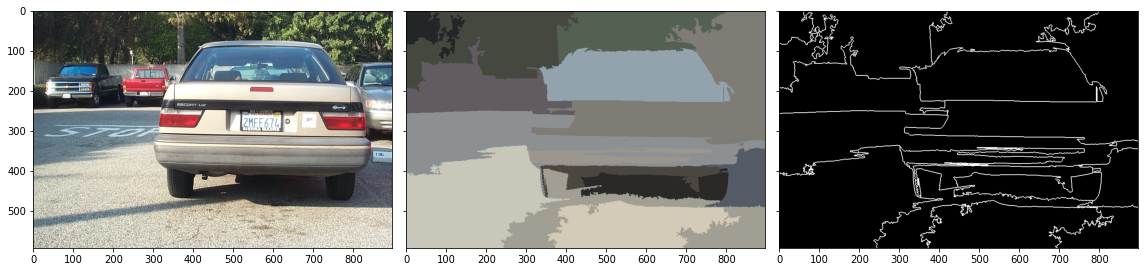

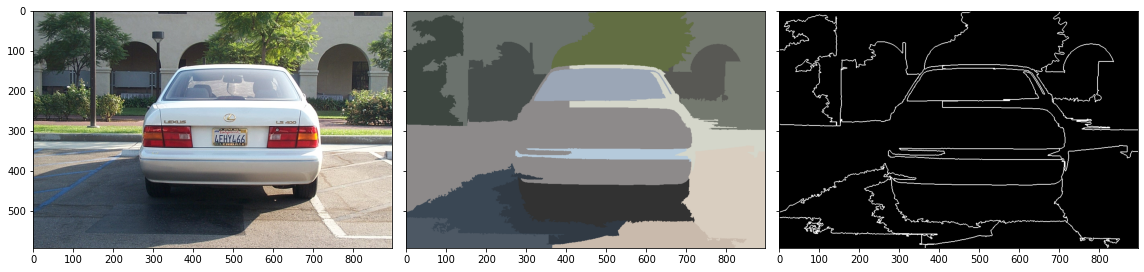

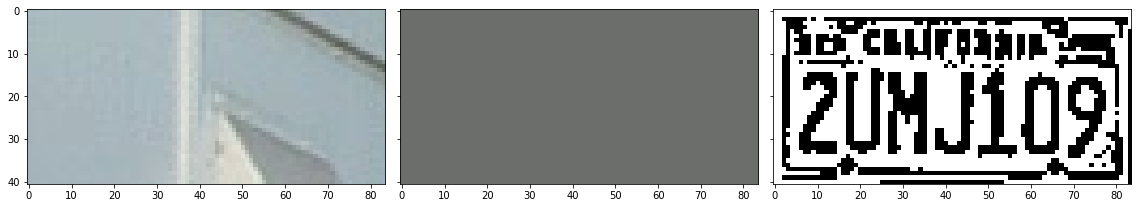

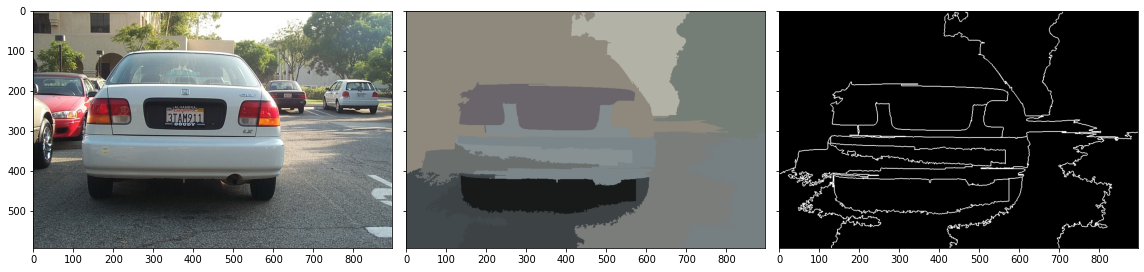

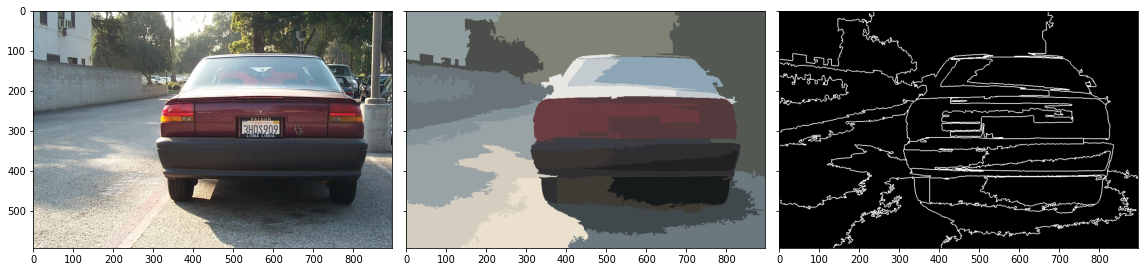

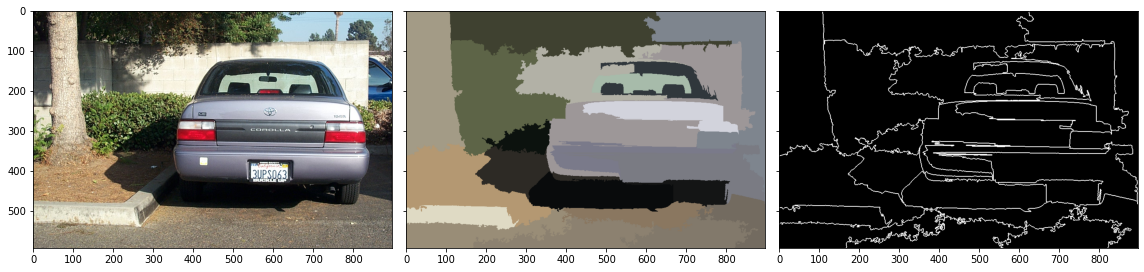

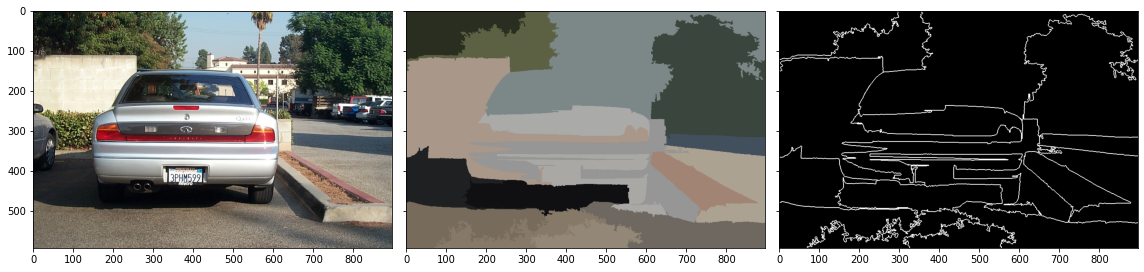

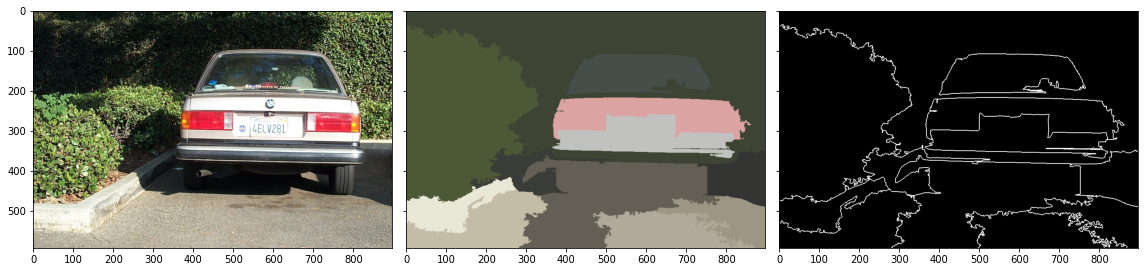

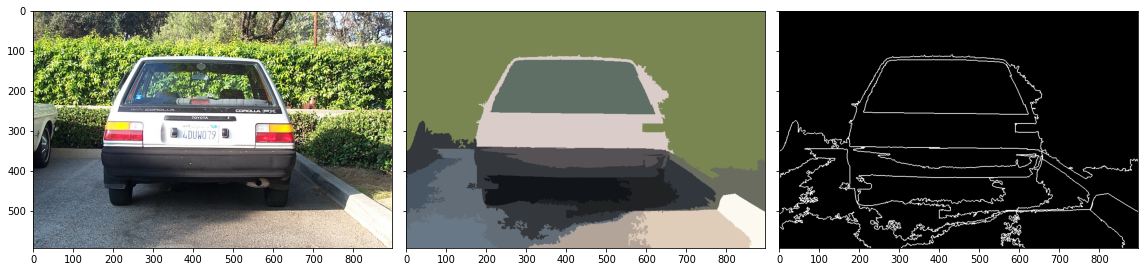

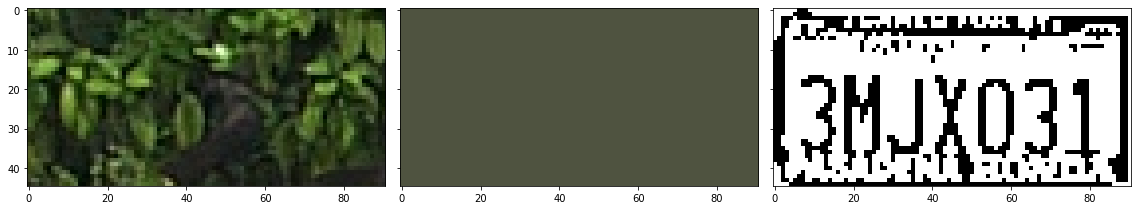

In [19]:
import glob
from pathlib import Path
n_processed = 0
n_found = 0

for img_path in Path("data/cars_markus").glob("*003*.jpg"):
    img = img_load(img_path)
    n_processed = n_processed + 1
    seg_labels = img_seg(img)
    (region_coords, box_coords) = find_rear_box(seg_labels)
    plate_area = extract_region(img, region_coords, box_coords)
    plate = find_plate(plate_area)
    if type(plate) is np.ndarray:
        plate_eq = hist_eq(plate)
        plate_bin = img_bin(plate_eq)
        n_found = n_found + 1
    else:
        continue
      

In [20]:
print(str(n_found) + ' out of ' + str(n_processed) + ' plates found.')

2 out of 11 plates found.


## Summary
Every country has their ownlicense plate format. So each country develops the LPR system appropriate for the vehicle license plate format.Difficulties that the LPR systems face are the environmental and non-uniform outdoor illumination conditions.Therefore, most of the systems work under restricted environmental conditions like fixed illumination, limitedvvehicle speed, designated routes, and stationary backgrounds
Our algorithm failed a some samples in side the dataset, due to back light condition.
The result from this project can be used to generate a traning dataset for maching learning.

Bright surroundings

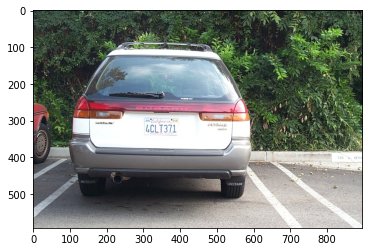

In [33]:
img = img_load('data/cars_markus/image_0075.jpg') 
plt.imshow(img)

Under exposure due to bright light

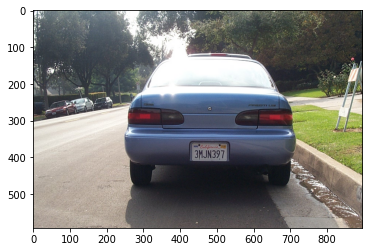

In [15]:
img = img_load('data/cars_markus/image_0102.jpg')
plt.imshow(img)

Covered by object

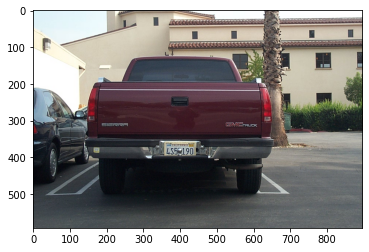

In [16]:
img = img_load('data/cars_markus/image_0120.jpg')
plt.imshow(img)